In [1]:
!pip install deap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install bitstring

     |████████████████████████████████| 195 kB 1.4 MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-py3-none-any.whl size=37946 sha256=2c4e5c28d77e6d5d03bf6abe16c3e30cb1c5d850aa251af301ec4a00e172b9e4
  Stored in directory: /root/.cache/pip/wheels/de/df/5d/fb4c06c6f1469ae5a826a471cab0cbb5661f6fff9be1cd493e
Successfully built bitstring
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 618 kB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59372 sha256=475244b41d3dfa810522caadfa3c0e80a5b2daff8199c9690a6bfb0304b27deb
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install tsaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [6]:
pwd

'/kaggle/working'

In [7]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [8]:
df = pd.read_csv('../input/covid-maroc-until-august-15/owid-covid-data.csv')

In [9]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36984 entries, 0 to 36983
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36920 non-null  object 
 1   continent                        36691 non-null  object 
 2   location                         36984 non-null  object 
 3   date                             36984 non-null  object 
 4   total_cases                      36632 non-null  float64
 5   new_cases                        36632 non-null  float64
 6   total_deaths                     36632 non-null  float64
 7   new_deaths                       36632 non-null  float64
 8   total_cases_per_million          36568 non-null  float64
 9   new_cases_per_million            36568 non-null  float64
 10  total_deaths_per_million         36568 non-null  float64
 11  new_deaths_per_million           36568 non-null  float64
 12  new_tests         

In [10]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [11]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [12]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [13]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [14]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [15]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [16]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [17]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [18]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [19]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [21]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [22]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [23]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [24]:
#df['month'] = df['date'].dt.month

In [25]:
nb_seq=1
n_out=7
nb_col=5

In [26]:
start_date = '2020-03-02'
end_date = '2020-07-13'
start_date2 ='2020-07-12'
end_date2 = '2020-08-15'

In [27]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [28]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [29]:
df.sort_values(by=['location'], inplace=True)


In [30]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(134, 7)

In [31]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [32]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [33]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [34]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [35]:
X_train.shape

(134, 7)

In [36]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [37]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23052,319.0,13288.0,230.0,1.0,36910558.0,2020-07-04,Morocco
23053,534.0,13822.0,232.0,2.0,36910558.0,2020-07-05,Morocco
23054,393.0,14215.0,235.0,3.0,36910558.0,2020-07-06,Morocco
23055,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
23056,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [38]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(35, 7)

In [39]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [40]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
1,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
2,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
3,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco
4,161.0,16097.0,257.0,2.0,36910558.0,2020-07-15,Morocco
5,165.0,16262.0,259.0,2.0,36910558.0,2020-07-16,Morocco
6,162.0,16424.0,260.0,1.0,36910558.0,2020-07-17,Morocco
7,302.0,16726.0,264.0,4.0,36910558.0,2020-07-18,Morocco
8,289.0,17015.0,269.0,5.0,36910558.0,2020-07-19,Morocco
9,221.0,17236.0,273.0,4.0,36910558.0,2020-07-20,Morocco


In [41]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [42]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [43]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [44]:
#days=days[nb_seq:]

In [45]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(134, 5)
(134, 1)
(36, 5)
(36, 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [47]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  \
1     0.010886   0.038999      0.040   0.000000        0.0  0.001555   
2     0.001555   0.000000      0.000   0.000000        0.0  0.010886   
3     0.010886   0.038999      0.040   0.000000        0.0  0.010886   
4     0.010886   0.038999      0.040   0.000000        0.0  0.001555   
5     0.001555   0.000064      0.000   0.000000        0.0  0.010886   
..         ...        ...        ...        ...        ...       ...   
123   0.160187   0.802528      0.912   0.000000        0.0  0.517885   
124   0.517885   0.823679      0.916   0.066667        0.0  0.496112   
125   0.496112   0.843940      0.920   0.066667        0.0  0.830482   
126   0.830482   0.877858      0.928   0.133333        0.0  0.611198   
127   0.611198   0.902820      0.940   0.200000        0.0  0.177294   

      var2(t)  var3(t)   var4(t)  var5(t)  ...  var1(t+5)  var2(t+5)  \
1    0.000000    0.000  0.000000      0.0  ...   0.010886   0.0

In [49]:
print(X_test)

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1    0.031390   0.008566   0.013661   0.148148        0.0  0.039611  0.000000   
2    0.039611   0.000000   0.000000   0.037037        0.0  0.031390  0.008566   
3    0.031390   0.008566   0.013661   0.148148        0.0  0.022422  0.016625   
4    0.022422   0.016625   0.027322   0.148148        0.0  0.000000  0.023419   
5    0.000000   0.023419   0.032787   0.037037        0.0  0.002990  0.030381   
6    0.002990   0.030381   0.038251   0.037037        0.0  0.000747  0.037217   
7    0.000747   0.037217   0.040984   0.000000        0.0  0.105381  0.049960   
8    0.105381   0.049960   0.051913   0.111111        0.0  0.095665  0.062154   
9    0.095665   0.062154   0.065574   0.148148        0.0  0.044843  0.071480   
10   0.044843   0.071480   0.076503   0.111111        0.0  0.123318  0.085236   
11   0.123318   0.085236   0.084699   0.074074        0.0  0.014200  0.092831   
12   0.014200   0.092831   0

In [50]:
#col_y_need_train = df.filter(regex=("d.*"))

In [51]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
1,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
2,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
3,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
4,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.004666,0.000254,0.004,0.066667,0.0
5,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.004666,0.000254,0.004,0.066667,0.0,0.001555,0.000318,0.004,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0,...,0.000000,0.910061,0.940,0.000000,0.0,0.687403,0.938135,0.968,0.466667,0.0
124,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0,...,0.687403,0.938135,0.968,0.466667,0.0,0.276827,0.949441,0.968,0.000000,0.0
125,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0,...,0.276827,0.949441,0.968,0.000000,0.0,0.589425,0.973514,0.972,0.066667,0.0
126,0.830482,0.877858,0.928,0.133333,0.0,0.611198,0.902820,0.940,0.200000,0.0,...,0.589425,0.973514,0.972,0.066667,0.0,0.332815,0.987106,0.980,0.133333,0.0


In [52]:
Y_train.head(5)

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.010886,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886
2,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886
3,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886
4,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555


In [53]:
#raise SystemExit("Stop right there!")

In [54]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [55]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [56]:
col_x_need_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.010886,0.038999,0.04,0.0,0.0


In [57]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886


In [58]:
#raise SystemExit("Stop right there!")

In [59]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [60]:
#col_x_need_train

In [61]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(127, 7)
(29, 7)


In [62]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886
2,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886
3,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886
4,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555


In [63]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(127, 5)
(29, 5)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.010886,0.038999,0.040,0.000000,0.0
2,0.001555,0.000000,0.000,0.000000,0.0
3,0.010886,0.038999,0.040,0.000000,0.0
4,0.010886,0.038999,0.040,0.000000,0.0
5,0.001555,0.000064,0.000,0.000000,0.0
...,...,...,...,...,...
123,0.160187,0.802528,0.912,0.000000,0.0
124,0.517885,0.823679,0.916,0.066667,0.0
125,0.496112,0.843940,0.920,0.066667,0.0
126,0.830482,0.877858,0.928,0.133333,0.0


In [64]:
X_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.031390,0.008566,0.013661,0.148148,0.0
2,0.039611,0.000000,0.000000,0.037037,0.0
3,0.031390,0.008566,0.013661,0.148148,0.0
4,0.022422,0.016625,0.027322,0.148148,0.0
5,0.000000,0.023419,0.032787,0.037037,0.0
6,0.002990,0.030381,0.038251,0.037037,0.0
7,0.000747,0.037217,0.040984,0.000000,0.0
8,0.105381,0.049960,0.051913,0.111111,0.0
9,0.095665,0.062154,0.065574,0.148148,0.0
10,0.044843,0.071480,0.076503,0.111111,0.0


In [65]:
print(X_test.shape)

(29, 5)


In [66]:
nb_col=5

In [67]:
X_test.head(1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.03139,0.008566,0.013661,0.148148,0.0


In [68]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(29, 1, 5) (29, 7) (127, 1, 5) (127, 7)


In [69]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(29, 1, 5) (29, 7) (127, 1, 5) (127, 7)


In [70]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [71]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [72]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    #print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=6,batch_size=1, validation_data=(X_test[[0,7,14,21,28]], Y_test[[0,7,14,21,28]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14,21,28]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14,21,28]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.1048
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1189
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.1021
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.1007
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0848
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0942
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 255)            2805      
_________________________________________________________________
flatten (Flatten)            (None, 255)               0         
_______

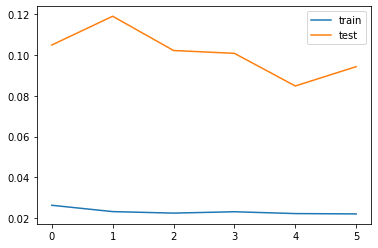

(127, 7)
(127, 7)
(127, 7)
score_train: [191.041] 172.3, 191.3, 193.2, 191.6, 187.7, 193.4, 206.2
(29, 1, 5)
score_test: [410.710] 359.1, 332.4, 157.3, 348.9, 524.3, 463.4, 552.5

RMSE test:  410.7100555318668 


Units CNN1:  254 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1041
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0969
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0750
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0759
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0959
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0783
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

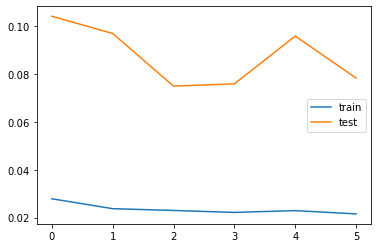

(127, 7)
(127, 7)
(127, 7)
score_train: [195.540] 182.2, 190.9, 205.9, 194.6, 195.9, 195.1, 203.2
(29, 1, 5)
score_test: [374.361] 290.4, 310.9, 200.2, 278.0, 538.1, 419.2, 466.2

RMSE test:  374.3608741049219 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1079
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0991
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0914
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0853
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0927
Epoch 6/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0851
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

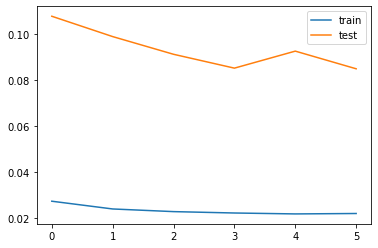

(127, 7)
(127, 7)
(127, 7)
score_train: [192.087] 172.0, 189.7, 196.5, 199.7, 186.0, 192.9, 206.1
(29, 1, 5)
score_test: [390.211] 340.6, 314.9, 135.1, 289.7, 503.4, 441.7, 547.7

RMSE test:  390.21094479102857 


Units CNN1:  223 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.1103
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.1102
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0897
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0825
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0832
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0846
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              P

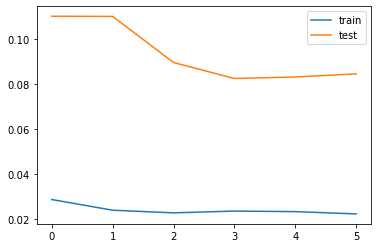

(127, 7)
(127, 7)
(127, 7)
score_train: [194.530] 173.1, 199.6, 200.0, 194.7, 184.7, 199.3, 208.2
(29, 1, 5)
score_test: [389.188] 366.5, 351.3, 138.3, 310.4, 497.9, 449.8, 486.7

RMSE test:  389.1883356023427 


Units CNN1:  127 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.1018
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0928
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0972
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1028
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0964
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0864
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

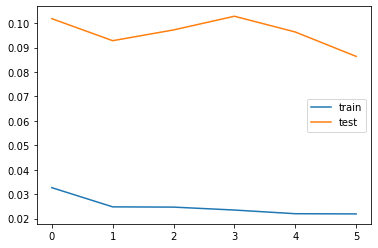

(127, 7)
(127, 7)
(127, 7)
score_train: [194.156] 174.8, 192.1, 203.2, 204.3, 186.7, 192.8, 203.3
(29, 1, 5)
score_test: [393.293] 335.0, 314.4, 185.7, 361.4, 520.0, 423.6, 506.6

RMSE test:  393.2926422020477 


Units CNN1:  191 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.1043
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.1082
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0791
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0835
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0876
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0789
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

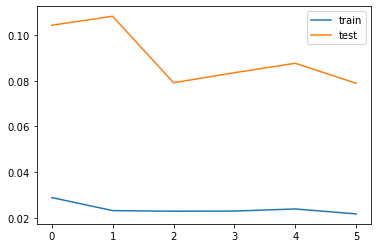

(127, 7)
(127, 7)
(127, 7)
score_train: [191.507] 172.1, 187.9, 195.9, 196.9, 186.6, 194.6, 204.9
(29, 1, 5)
score_test: [375.839] 341.3, 323.8, 153.1, 305.6, 458.8, 395.3, 532.8

RMSE test:  375.8387553144122 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1085
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0905
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0857
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0912
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0877
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0886
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

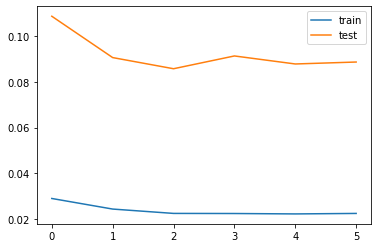

(127, 7)
(127, 7)
(127, 7)
score_train: [190.948] 177.8, 189.2, 192.9, 196.4, 182.9, 192.7, 203.7
(29, 1, 5)
score_test: [398.214] 387.5, 329.9, 150.5, 343.4, 502.2, 449.3, 506.3

RMSE test:  398.21386683307355 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0986
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.1045
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0896
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1077
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0918
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0920
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              P

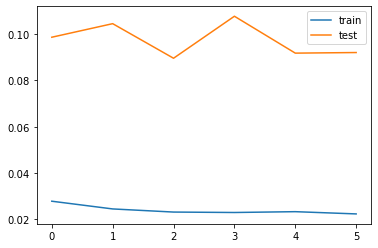

(127, 7)
(127, 7)
(127, 7)
score_train: [190.327] 173.5, 187.7, 190.9, 194.0, 184.6, 192.5, 207.4
(29, 1, 5)
score_test: [405.892] 352.8, 313.9, 158.7, 332.6, 517.1, 458.6, 562.7

RMSE test:  405.89211977254746 


Units CNN1:  127 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0893
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.1001
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0848
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0890
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0873
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0820
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              P

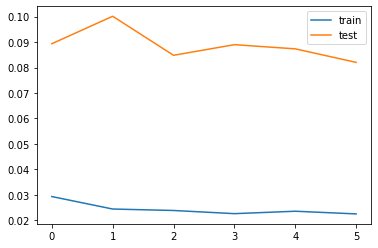

(127, 7)
(127, 7)
(127, 7)
score_train: [190.749] 171.8, 187.5, 194.2, 195.7, 185.6, 192.5, 206.2
(29, 1, 5)
score_test: [383.209] 336.0, 284.3, 153.6, 319.6, 468.7, 431.2, 550.3

RMSE test:  383.208664884951 


Units CNN1:  223 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1139
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.1015
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1036
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0912
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0903
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0950
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Par

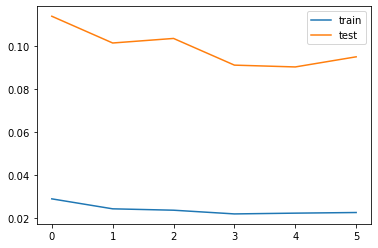

(127, 7)
(127, 7)
(127, 7)
score_train: [193.350] 174.4, 194.1, 199.5, 195.2, 189.1, 193.9, 205.7
(29, 1, 5)
score_test: [412.494] 380.3, 341.1, 199.5, 337.2, 485.0, 479.3, 558.3

RMSE test:  412.49374593525243 

gen	nevals	avg    	std    	min    	max   
0  	10    	377.996	10.9048	374.361	410.71

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1052
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0957
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0843
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0715
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0856
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0871
Model: "sequential_10"
_____________________________________

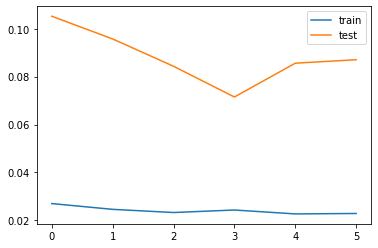

(127, 7)
(127, 7)
(127, 7)
score_train: [190.480] 172.3, 188.0, 195.7, 195.4, 184.5, 192.1, 203.7
(29, 1, 5)
score_test: [394.797] 354.0, 313.5, 154.2, 342.8, 509.3, 446.1, 517.4

RMSE test:  394.79736464168917 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.1195
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.1129
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0939
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0784
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0796
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0888
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              

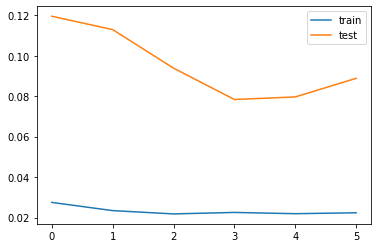

(127, 7)
(127, 7)
(127, 7)
score_train: [191.282] 173.7, 187.5, 195.5, 195.1, 183.9, 195.6, 205.9
(29, 1, 5)
score_test: [398.793] 365.1, 331.4, 149.7, 342.5, 477.9, 478.8, 522.3

RMSE test:  398.7925697680415 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 4ms/step - loss: 0.0315 - val_loss: 0.1088
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1140
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1004
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0919
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0907
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0905
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              P

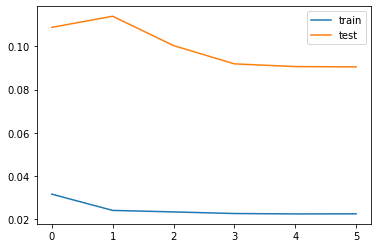

(127, 7)
(127, 7)
(127, 7)
score_train: [191.961] 182.9, 186.8, 198.7, 192.3, 185.6, 192.7, 203.9
(29, 1, 5)
score_test: [402.595] 386.7, 304.2, 181.2, 319.2, 520.1, 468.3, 517.7

RMSE test:  402.59462839485803 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0291 - val_loss: 0.0992
Epoch 2/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0915
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.1042
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.1016
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0776
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0998
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              

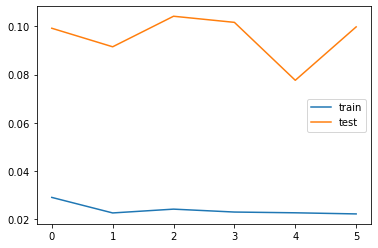

(127, 7)
(127, 7)
(127, 7)
score_train: [196.150] 172.9, 188.5, 193.1, 204.6, 190.8, 204.6, 215.6
(29, 1, 5)
score_test: [422.604] 349.9, 301.5, 143.1, 380.2, 541.6, 491.9, 580.1

RMSE test:  422.6037669640608 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.1099
Epoch 2/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.0963
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0951
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0800
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0781
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0890
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              P

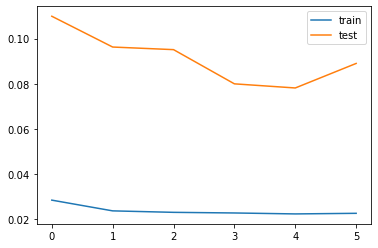

(127, 7)
(127, 7)
(127, 7)
score_train: [191.853] 172.7, 187.4, 192.1, 194.4, 197.7, 193.7, 203.5
(29, 1, 5)
score_test: [399.176] 320.8, 288.2, 149.2, 348.3, 560.6, 442.4, 525.2

RMSE test:  399.1756502639816 


Units CNN1:  253 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.1047
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0922
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0857
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0740
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0808
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0878
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              P

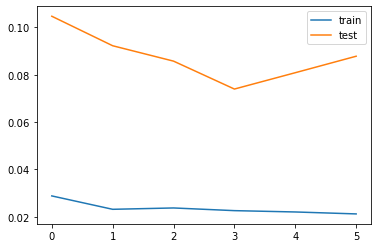

(127, 7)
(127, 7)
(127, 7)
score_train: [192.879] 173.4, 188.1, 202.0, 198.1, 184.0, 197.7, 204.9
(29, 1, 5)
score_test: [396.472] 351.0, 315.6, 206.3, 327.9, 492.5, 464.2, 519.0

RMSE test:  396.4721226464951 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1168
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0788
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0797
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0894
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.1005
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0737
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              P

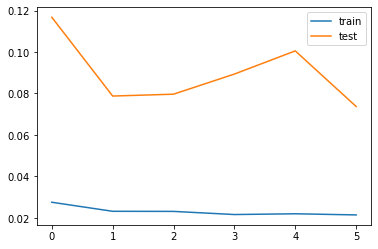

(127, 7)
(127, 7)
(127, 7)
score_train: [193.915] 173.0, 190.1, 197.9, 201.2, 193.5, 192.0, 207.8
(29, 1, 5)
score_test: [363.296] 347.0, 286.5, 115.0, 270.0, 446.6, 455.2, 478.2

RMSE test:  363.29644304325257 


Units CNN1:  223 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0999
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1005
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0782
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0739
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0802
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0791
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              

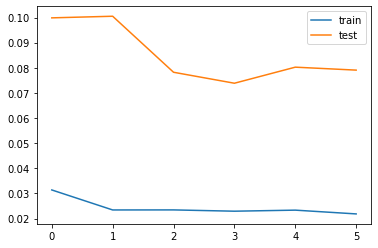

(127, 7)
(127, 7)
(127, 7)
score_train: [191.979] 175.1, 188.9, 197.1, 197.8, 184.1, 193.1, 206.1
(29, 1, 5)
score_test: [376.240] 350.8, 298.1, 121.4, 250.9, 468.7, 430.4, 544.4

RMSE test:  376.2395267928941 


Units CNN1:  254 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.1158
Epoch 2/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0886
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0882
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0778
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0843
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0926
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              P

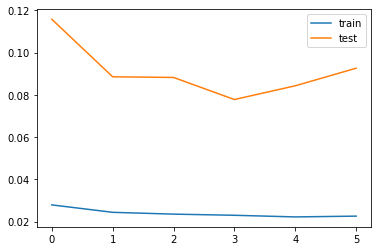

(127, 7)
(127, 7)
(127, 7)
score_train: [196.061] 171.8, 193.9, 215.7, 196.0, 186.4, 192.6, 212.7
(29, 1, 5)
score_test: [407.196] 348.2, 344.4, 231.8, 262.1, 506.8, 454.5, 578.8

RMSE test:  407.1959966812372 


Units CNN1:  127 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.1095
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1018
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0915
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0984
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0912
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0797
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              P

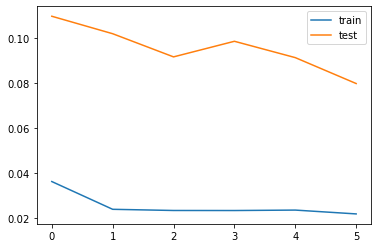

(127, 7)
(127, 7)
(127, 7)
score_train: [191.445] 173.1, 189.0, 195.4, 193.5, 189.8, 194.4, 203.6
(29, 1, 5)
score_test: [377.750] 355.4, 275.4, 134.1, 279.7, 538.9, 409.5, 492.4

RMSE test:  377.7495878311613 

1  	10    	369.935	5.42044	363.296	374.361

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0985
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0960
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0837
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.1032
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0922
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0930
Model: "sequential_20"
_________________________________________________________________
Layer (type) 

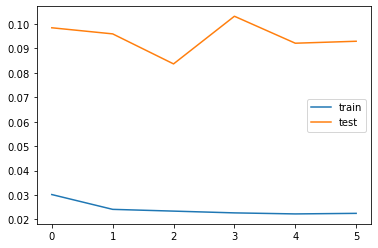

(127, 7)
(127, 7)
(127, 7)
score_train: [193.513] 177.9, 200.8, 194.7, 197.3, 186.3, 193.2, 203.2
(29, 1, 5)
score_test: [407.958] 375.8, 350.7, 176.7, 346.8, 505.1, 477.7, 515.7

RMSE test:  407.95804614317535 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0971
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1185
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0926
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0823
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1027
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1025
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              

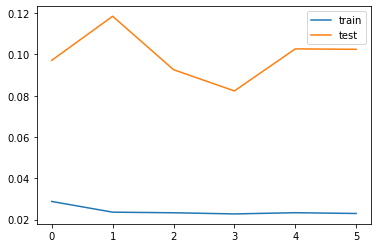

(127, 7)
(127, 7)
(127, 7)
score_train: [191.892] 174.9, 185.5, 193.7, 192.3, 195.0, 192.1, 208.2
(29, 1, 5)
score_test: [428.319] 385.9, 319.1, 185.6, 352.8, 557.9, 486.7, 571.4

RMSE test:  428.31933896225837 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0285 - val_loss: 0.1154
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0936
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0877
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0876
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0830
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0836
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              

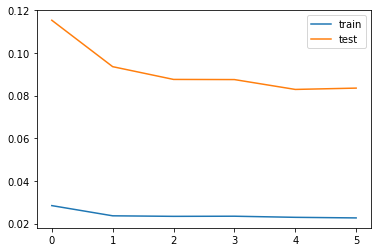

(127, 7)
(127, 7)
(127, 7)
score_train: [192.459] 172.3, 187.8, 194.8, 207.4, 185.0, 195.6, 202.2
(29, 1, 5)
score_test: [386.814] 334.1, 305.3, 169.5, 276.2, 483.5, 481.3, 521.6

RMSE test:  386.81408248361396 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.1296
Epoch 2/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0241 - val_loss: 0.1022
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0967
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0890
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0977
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0900
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              

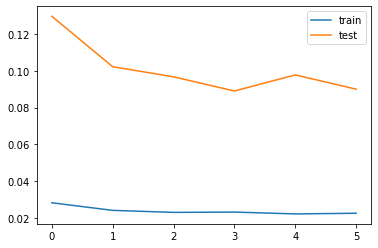

(127, 7)
(127, 7)
(127, 7)
score_train: [192.478] 173.0, 191.1, 193.2, 199.6, 189.8, 193.7, 205.3
(29, 1, 5)
score_test: [401.402] 348.9, 342.8, 173.9, 293.7, 559.0, 466.4, 492.1

RMSE test:  401.4015576539023 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1166
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0941
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0922
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.1067
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0832
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0795
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              P

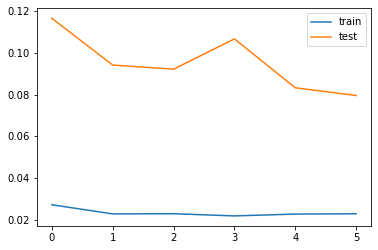

(127, 7)
(127, 7)
(127, 7)
score_train: [190.344] 172.8, 189.6, 194.1, 193.5, 184.2, 192.8, 203.9
(29, 1, 5)
score_test: [377.298] 347.9, 271.0, 151.2, 309.4, 475.9, 445.3, 508.6

RMSE test:  377.29774086048974 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0961
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.1078
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0957
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.1040
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0830
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0718
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              

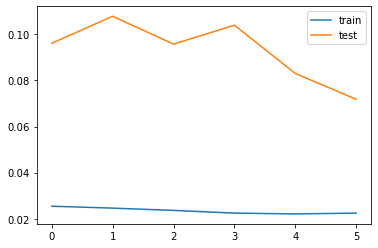

(127, 7)
(127, 7)
(127, 7)
score_train: [196.313] 173.9, 190.4, 206.8, 200.5, 197.9, 198.4, 204.4
(29, 1, 5)
score_test: [358.605] 345.0, 290.0, 106.6, 267.5, 432.0, 415.7, 504.7

RMSE test:  358.605081998409 


Units CNN1:  127 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.1294
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.1126
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.1033
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0889
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0892
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0933
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

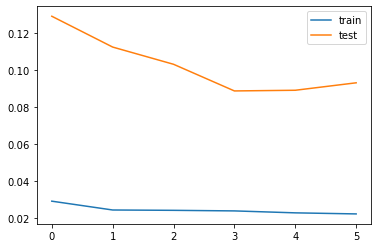

(127, 7)
(127, 7)
(127, 7)
score_train: [191.469] 180.1, 188.4, 194.3, 193.9, 184.2, 194.0, 204.4
(29, 1, 5)
score_test: [408.637] 404.7, 334.7, 144.9, 328.7, 500.4, 498.4, 514.9

RMSE test:  408.6372418205735 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.1023
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0854
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0706
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0848
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0797
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0754
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              P

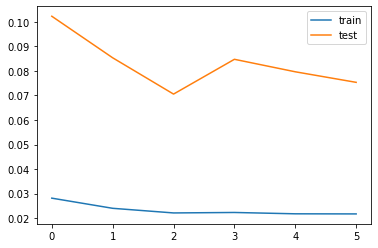

(127, 7)
(127, 7)
(127, 7)
score_train: [194.149] 173.5, 187.8, 192.5, 213.9, 185.0, 199.6, 204.0
(29, 1, 5)
score_test: [367.317] 338.8, 280.5, 132.8, 254.9, 476.7, 411.7, 521.2

RMSE test:  367.3173644273055 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.1219
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0804
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.1046
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0865
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.1007
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0833
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              P

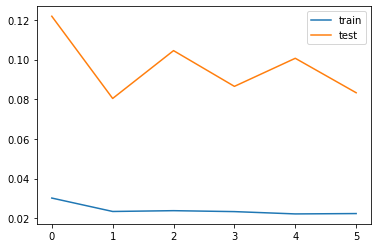

(127, 7)
(127, 7)
(127, 7)
score_train: [193.145] 179.2, 189.7, 197.4, 196.0, 184.5, 199.5, 204.5
(29, 1, 5)
score_test: [386.175] 331.6, 287.3, 198.0, 350.7, 510.8, 400.7, 517.5

RMSE test:  386.17451016314743 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.1099
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0968
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0892
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.1101
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0871
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0846
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              

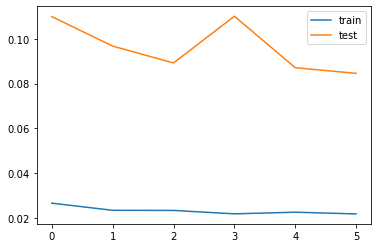

(127, 7)
(127, 7)
(127, 7)
score_train: [193.730] 178.2, 191.2, 194.3, 203.6, 190.5, 193.4, 203.8
(29, 1, 5)
score_test: [389.137] 326.2, 289.9, 168.2, 366.9, 477.4, 442.6, 531.9

RMSE test:  389.1372316200315 

2  	10    	360.951	2.34568	358.605	363.296

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 4ms/step - loss: 0.0295 - val_loss: 0.0999
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0988
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0821
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0912
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0769
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0819
Model: "sequential_30"
_________________________________________________________________
Layer (type) 

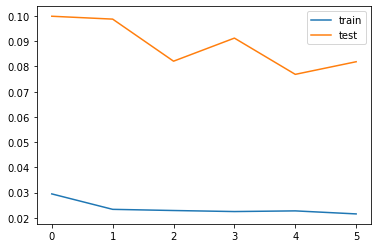

(127, 7)
(127, 7)
(127, 7)
score_train: [190.283] 172.8, 188.9, 192.4, 191.0, 189.5, 192.3, 203.8
(29, 1, 5)
score_test: [382.859] 325.1, 292.6, 139.7, 311.7, 518.0, 445.5, 501.3

RMSE test:  382.85914484265254 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1072
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0776
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0965
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0797
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0759
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0802
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              

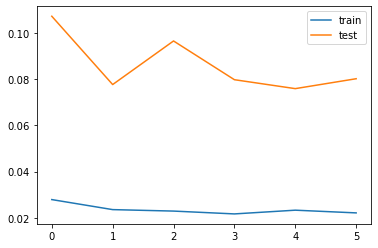

(127, 7)
(127, 7)
(127, 7)
score_train: [189.316] 171.7, 186.2, 193.6, 193.7, 184.8, 191.4, 202.3
(29, 1, 5)
score_test: [378.820] 346.5, 307.5, 123.1, 317.3, 474.4, 457.1, 490.0

RMSE test:  378.82009458617136 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1061
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1000
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0984
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0949
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0985
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0830
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              

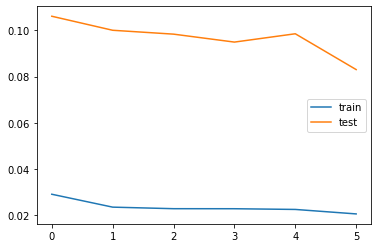

(127, 7)
(127, 7)
(127, 7)
score_train: [190.411] 176.0, 187.4, 195.2, 195.6, 184.1, 192.4, 201.0
(29, 1, 5)
score_test: [385.527] 372.8, 315.6, 130.0, 327.0, 463.4, 453.3, 507.7

RMSE test:  385.52697907971867 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1096
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0935
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0816
Epoch 4/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.1045
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0814
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0814
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              

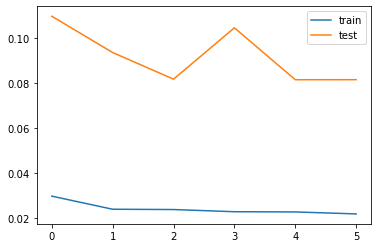

(127, 7)
(127, 7)
(127, 7)
score_train: [193.238] 172.3, 187.4, 193.4, 198.9, 186.6, 205.7, 206.3
(29, 1, 5)
score_test: [381.773] 337.8, 297.3, 135.2, 266.5, 451.8, 489.8, 533.3

RMSE test:  381.77322870149163 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1040
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.1045
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0914
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0914
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0854
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0756
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              

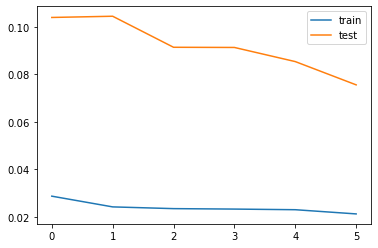

(127, 7)
(127, 7)
(127, 7)
score_train: [193.835] 173.7, 188.4, 205.9, 192.2, 187.0, 197.1, 210.1
(29, 1, 5)
score_test: [367.882] 354.9, 293.2, 132.8, 310.4, 479.2, 418.7, 465.3

RMSE test:  367.8821100295251 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1182
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0926
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0989
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0988
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0901
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0935
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              P

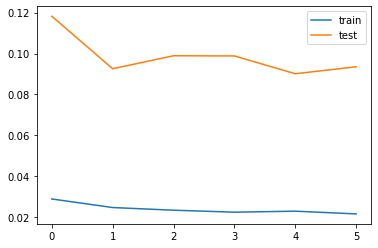

(127, 7)
(127, 7)
(127, 7)
score_train: [193.632] 180.0, 191.0, 195.6, 192.8, 187.1, 200.8, 207.0
(29, 1, 5)
score_test: [409.219] 391.4, 326.4, 174.3, 322.2, 513.7, 486.5, 527.0

RMSE test:  409.2187549343708 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1135
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0958
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0854
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0954
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0843
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0958
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              P

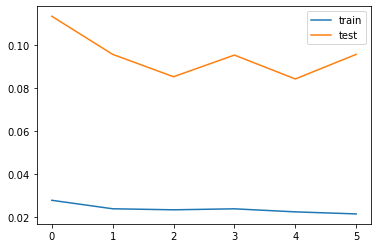

(127, 7)
(127, 7)
(127, 7)
score_train: [196.411] 176.3, 188.2, 195.1, 208.7, 196.5, 198.8, 209.3
(29, 1, 5)
score_test: [414.078] 365.1, 318.8, 172.2, 361.5, 530.5, 464.7, 554.5

RMSE test:  414.0780071325721 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0857
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1145
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0798
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0899
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0863
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0839
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              P

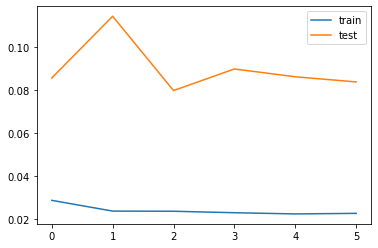

(127, 7)
(127, 7)
(127, 7)
score_train: [190.772] 173.5, 186.9, 192.6, 193.4, 184.5, 196.6, 206.2
(29, 1, 5)
score_test: [387.450] 336.9, 305.3, 168.3, 312.2, 480.5, 432.3, 548.2

RMSE test:  387.4497718025503 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1081
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0832
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0908
Epoch 4/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0863
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0896
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0836
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              P

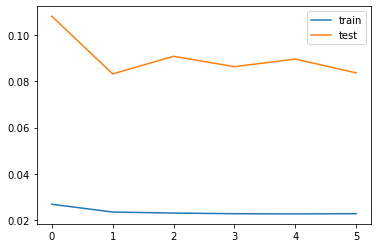

(127, 7)
(127, 7)
(127, 7)
score_train: [192.318] 176.7, 189.6, 193.8, 194.2, 190.1, 192.8, 207.7
(29, 1, 5)
score_test: [386.887] 367.3, 278.2, 151.9, 320.1, 519.4, 460.5, 477.6

RMSE test:  386.88685119549234 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.1164
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1103
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0938
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0995
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0993
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0885
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              

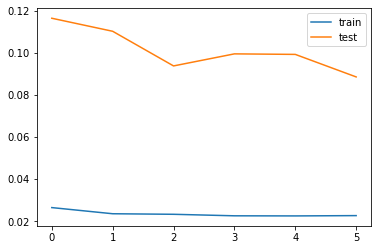

(127, 7)
(127, 7)
(127, 7)
score_train: [191.735] 174.1, 188.3, 200.8, 196.4, 183.9, 193.1, 203.9
(29, 1, 5)
score_test: [398.151] 358.8, 342.4, 123.4, 343.3, 497.7, 446.6, 532.4

RMSE test:  398.15070848903565 

3  	10    	358.605	0      	358.605	358.605

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.1067
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0879
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0880
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0813
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0675
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.1033
Model: "sequential_40"
_________________________________________________________________
Layer (type)

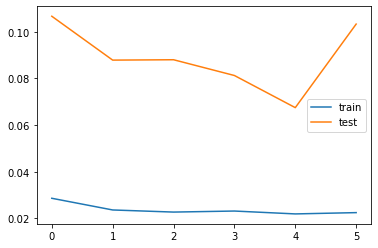

(127, 7)
(127, 7)
(127, 7)
score_train: [195.029] 176.3, 188.9, 195.8, 200.5, 190.0, 196.9, 214.6
(29, 1, 5)
score_test: [430.105] 357.5, 321.3, 205.7, 373.1, 521.1, 509.3, 592.8

RMSE test:  430.105461954419 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.1129
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.1066
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0760
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.1037
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0945
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0745
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

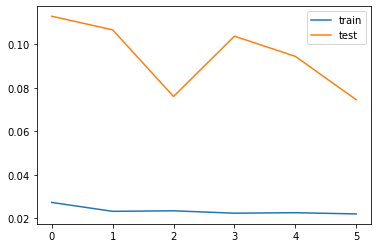

(127, 7)
(127, 7)
(127, 7)
score_train: [192.481] 171.1, 192.8, 192.4, 194.6, 187.8, 193.0, 213.4
(29, 1, 5)
score_test: [365.244] 317.9, 325.4, 152.8, 312.2, 448.7, 425.5, 473.0

RMSE test:  365.24369873590166 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0955
Epoch 2/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.1019
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0768
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0977
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0722
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0674
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              

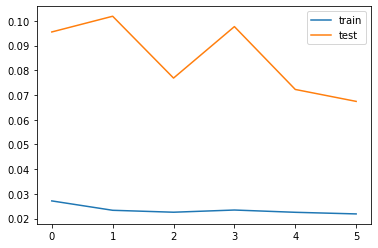

(127, 7)
(127, 7)
(127, 7)
score_train: [197.898] 187.3, 201.7, 194.1, 196.6, 184.5, 210.4, 209.2
(29, 1, 5)
score_test: [347.381] 303.4, 259.8, 149.1, 286.1, 466.0, 373.4, 473.8

RMSE test:  347.38096502704434 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0931
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1001
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0740
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0937
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0804
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0748
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              

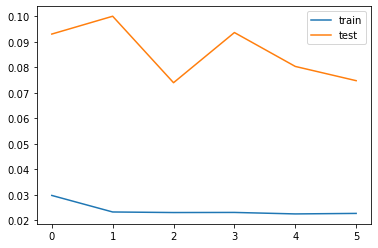

(127, 7)
(127, 7)
(127, 7)
score_train: [195.005] 173.2, 199.3, 202.2, 196.5, 186.4, 194.9, 210.4
(29, 1, 5)
score_test: [365.955] 326.5, 251.2, 101.3, 294.9, 508.5, 431.3, 475.2

RMSE test:  365.9548346840971 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.1072
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1023
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0936
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0712
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0856
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0875
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              P

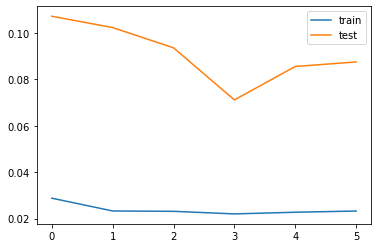

(127, 7)
(127, 7)
(127, 7)
score_train: [191.676] 173.3, 188.3, 195.4, 195.5, 185.3, 193.1, 208.9
(29, 1, 5)
score_test: [395.791] 377.6, 284.6, 165.6, 294.4, 486.6, 475.4, 544.1

RMSE test:  395.7907157166934 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1181
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1230
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0920
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0808
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0789
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0853
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              P

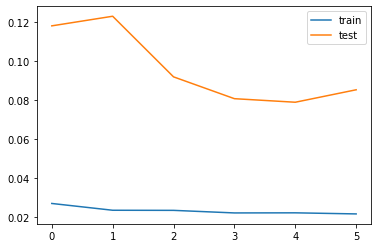

(127, 7)
(127, 7)
(127, 7)
score_train: [192.202] 172.5, 189.4, 193.9, 197.0, 184.3, 198.0, 208.4
(29, 1, 5)
score_test: [390.847] 353.1, 294.3, 191.2, 368.9, 484.4, 486.2, 463.0

RMSE test:  390.8466869754525 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0976
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.1045
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0722
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0892
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0885
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0900
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              P

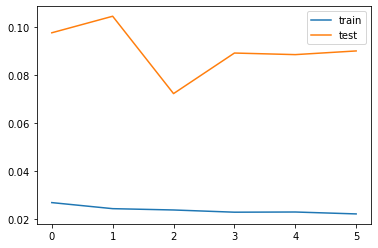

(127, 7)
(127, 7)
(127, 7)
score_train: [192.152] 176.6, 190.4, 194.1, 194.0, 187.7, 194.6, 206.4
(29, 1, 5)
score_test: [401.478] 378.9, 323.4, 135.1, 306.2, 506.0, 451.9, 554.9

RMSE test:  401.477888717984 

4  	7     	352.993	5.61206	347.381	358.605

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.1001
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0973
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0896
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0826
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0752
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0950
Model: "sequential_47"
_________________________________________________________________
Layer (type)  

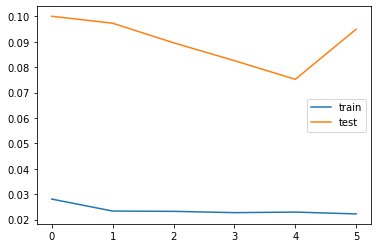

(127, 7)
(127, 7)
(127, 7)
score_train: [195.603] 172.6, 185.9, 209.4, 192.5, 186.6, 203.6, 215.3
(29, 1, 5)
score_test: [412.362] 343.1, 305.2, 236.3, 285.8, 522.8, 506.1, 559.0

RMSE test:  412.36174358876514 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1114
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0969
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0785
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0783
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0847
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.1068
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              

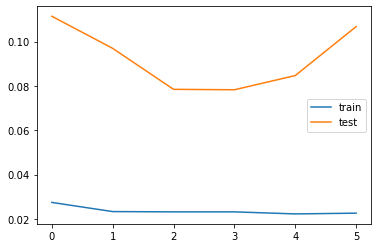

(127, 7)
(127, 7)
(127, 7)
score_train: [203.880] 194.5, 218.0, 206.6, 206.2, 192.1, 205.2, 203.5
(29, 1, 5)
score_test: [437.191] 438.7, 398.0, 225.7, 374.8, 517.6, 504.7, 522.5

RMSE test:  437.19095859921526 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 6ms/step - loss: 0.0287 - val_loss: 0.0957
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0969
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0902
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0846
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0899
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0657
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              

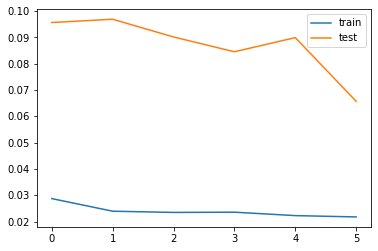

(127, 7)
(127, 7)
(127, 7)
score_train: [198.644] 190.8, 188.0, 198.8, 207.2, 191.8, 207.0, 206.0
(29, 1, 5)
score_test: [343.037] 285.4, 293.4, 108.1, 249.6, 449.5, 378.2, 486.9

RMSE test:  343.0372783973723 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1023
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1175
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.1016
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1047
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.1117
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0775
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              P

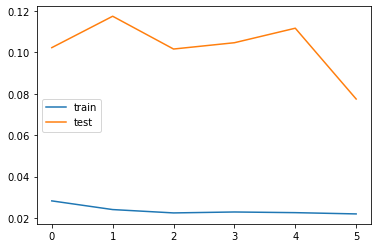

(127, 7)
(127, 7)
(127, 7)
score_train: [193.697] 173.8, 197.1, 197.4, 197.2, 183.4, 202.7, 202.5
(29, 1, 5)
score_test: [372.461] 333.8, 267.4, 124.7, 302.2, 481.3, 411.2, 529.6

RMSE test:  372.4610172609429 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1115
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1100
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0914
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.1041
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0932
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0856
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              P

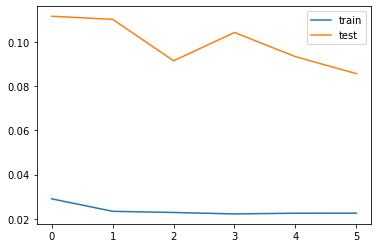

(127, 7)
(127, 7)
(127, 7)
score_train: [191.088] 174.1, 187.3, 198.5, 194.3, 185.1, 194.0, 202.9
(29, 1, 5)
score_test: [391.430] 350.4, 320.7, 127.3, 354.0, 512.2, 437.5, 501.5

RMSE test:  391.4303821967862 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0997
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.1018
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0858
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0865
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0891
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0809
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              P

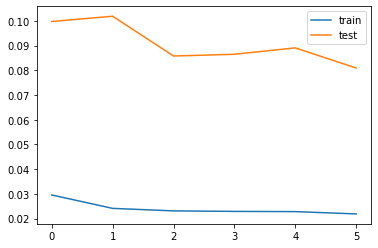

(127, 7)
(127, 7)
(127, 7)
score_train: [191.545] 173.3, 187.7, 193.5, 199.4, 186.5, 193.6, 205.2
(29, 1, 5)
score_test: [380.611] 331.6, 315.3, 137.3, 359.6, 456.3, 417.9, 523.1

RMSE test:  380.61053536040544 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1151
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0992
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0746
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0939
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0822
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0716
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              

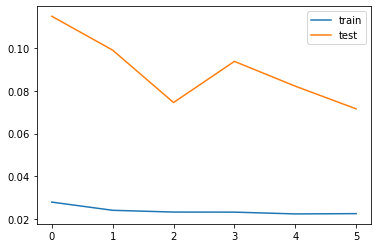

(127, 7)
(127, 7)
(127, 7)
score_train: [191.222] 173.1, 186.7, 197.1, 196.2, 184.5, 192.7, 206.4
(29, 1, 5)
score_test: [357.973] 323.3, 299.5, 125.1, 298.9, 470.6, 401.5, 463.9

RMSE test:  357.97321673229095 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.1031
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1032
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0842
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0891
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0843
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0686
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              

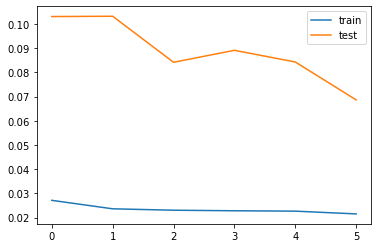

(127, 7)
(127, 7)
(127, 7)
score_train: [201.108] 175.9, 204.9, 201.3, 194.5, 188.0, 203.7, 234.6
(29, 1, 5)
score_test: [350.513] 329.1, 247.6, 132.0, 292.4, 523.2, 400.6, 391.6

RMSE test:  350.513344425347 

5  	8     	344.775	2.12796	343.037	347.381

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1188
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1140
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.1064
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.1052
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0781
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0829
Model: "sequential_55"
_________________________________________________________________
Layer (type)  

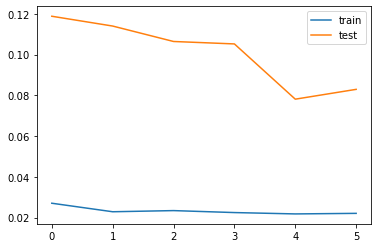

(127, 7)
(127, 7)
(127, 7)
score_train: [193.263] 180.6, 190.4, 194.2, 204.6, 184.3, 191.5, 205.7
(29, 1, 5)
score_test: [385.274] 317.5, 277.0, 152.7, 312.2, 505.9, 442.1, 537.8

RMSE test:  385.2740193960832 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0995
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1033
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0857
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0872
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0797
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0659
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              P

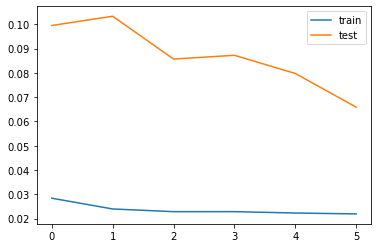

(127, 7)
(127, 7)
(127, 7)
score_train: [195.739] 173.5, 186.8, 204.2, 206.2, 197.4, 195.9, 204.1
(29, 1, 5)
score_test: [343.450] 316.5, 294.4, 115.5, 264.4, 418.7, 389.3, 478.2

RMSE test:  343.4500541809619 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1188
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1047
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0951
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0958
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0952
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0983
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              P

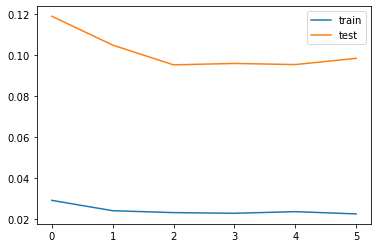

(127, 7)
(127, 7)
(127, 7)
score_train: [194.370] 189.3, 193.3, 194.6, 195.7, 185.6, 193.0, 208.3
(29, 1, 5)
score_test: [419.399] 414.4, 335.0, 165.0, 369.0, 513.6, 470.4, 546.6

RMSE test:  419.3986421358259 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.1178
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0964
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1011
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.1052
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0924
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0938
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              P

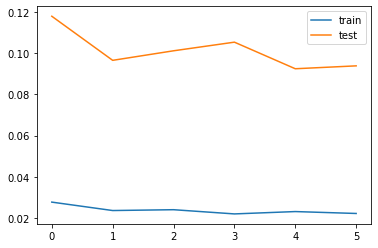

(127, 7)
(127, 7)
(127, 7)
score_train: [191.568] 176.3, 189.8, 196.1, 194.2, 184.0, 194.3, 205.0
(29, 1, 5)
score_test: [409.685] 393.0, 326.3, 173.0, 327.6, 511.2, 456.1, 554.4

RMSE test:  409.68473038234583 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0980
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0978
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0641
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0829
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0836
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0763
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              

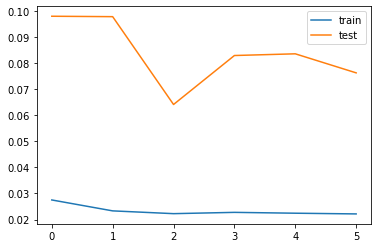

(127, 7)
(127, 7)
(127, 7)
score_train: [192.649] 173.0, 189.6, 194.7, 193.0, 185.2, 205.6, 205.5
(29, 1, 5)
score_test: [369.480] 320.1, 295.8, 171.4, 312.1, 492.3, 406.1, 481.3

RMSE test:  369.47966080316496 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.1038
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1051
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0974
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0983
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0815
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0927
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              

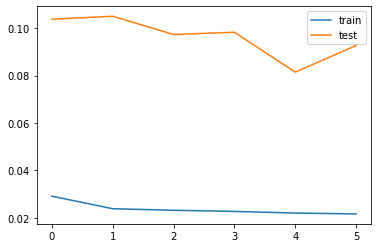

(127, 7)
(127, 7)
(127, 7)
score_train: [194.619] 179.3, 191.0, 210.5, 193.1, 183.4, 191.4, 211.2
(29, 1, 5)
score_test: [407.436] 384.6, 329.7, 212.8, 323.5, 499.2, 439.3, 559.7

RMSE test:  407.4361699258867 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.1147
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0953
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0974
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0891
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0925
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0850
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              P

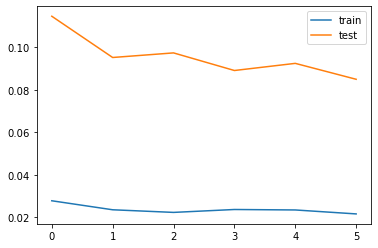

(127, 7)
(127, 7)
(127, 7)
score_train: [193.557] 178.2, 191.7, 197.0, 204.9, 183.7, 194.5, 203.5
(29, 1, 5)
score_test: [390.047] 298.1, 274.0, 160.9, 371.2, 478.8, 457.0, 547.1

RMSE test:  390.0474263628304 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1177
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1043
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0866
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0928
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0896
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.1019
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              P

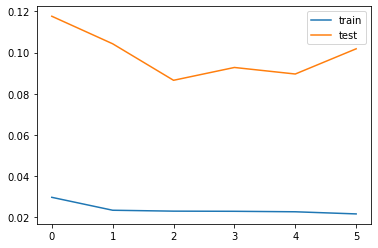

(127, 7)
(127, 7)
(127, 7)
score_train: [198.039] 177.9, 189.4, 195.2, 198.9, 203.0, 213.3, 206.6
(29, 1, 5)
score_test: [427.015] 400.0, 314.1, 166.1, 338.5, 550.1, 524.7, 545.6

RMSE test:  427.01532837323407 

6  	8     	343.037	5.68434e-14	343.037	343.037

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1165
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0997
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0832
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0750
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0793
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0762
Model: "sequential_63"
_________________________________________________________________
Layer (t

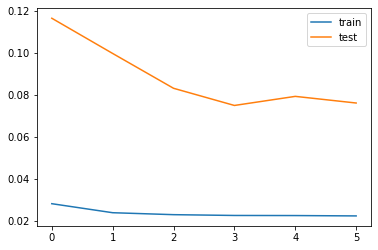

(127, 7)
(127, 7)
(127, 7)
score_train: [191.540] 181.1, 186.6, 194.3, 194.2, 186.8, 193.7, 203.2
(29, 1, 5)
score_test: [369.245] 292.7, 279.6, 157.3, 280.4, 482.9, 444.2, 506.6

RMSE test:  369.24504269578415 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1032
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0875
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0961
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0809
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0865
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0879
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              

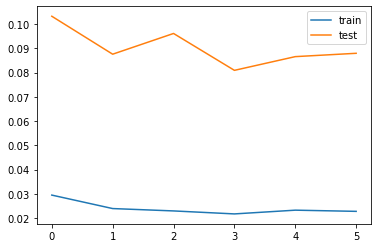

(127, 7)
(127, 7)
(127, 7)
score_train: [193.603] 174.3, 190.0, 202.7, 196.0, 188.9, 195.2, 206.4
(29, 1, 5)
score_test: [396.721] 367.5, 325.1, 192.9, 313.7, 526.0, 455.5, 491.0

RMSE test:  396.72057105837365 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1005
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0767
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0971
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0960
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0844
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0779
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              

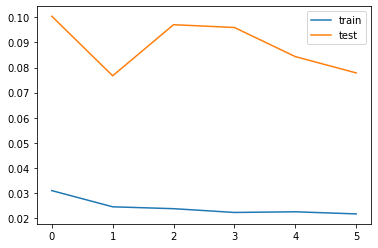

(127, 7)
(127, 7)
(127, 7)
score_train: [195.386] 172.3, 188.5, 222.8, 194.1, 187.9, 193.6, 204.8
(29, 1, 5)
score_test: [373.346] 335.1, 299.4, 85.5, 321.0, 468.8, 399.5, 533.0

RMSE test:  373.34621016669274 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.1060
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1005
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0873
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0925
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0777
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0889
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              P

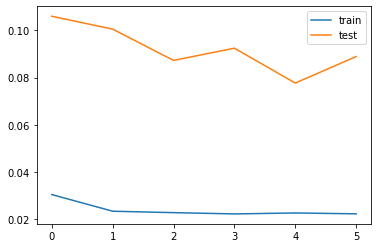

(127, 7)
(127, 7)
(127, 7)
score_train: [191.058] 174.3, 187.8, 196.1, 192.6, 187.7, 195.5, 202.2
(29, 1, 5)
score_test: [398.944] 346.5, 316.0, 186.5, 326.2, 523.9, 462.2, 514.8

RMSE test:  398.943844861631 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0903
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0827
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0803
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.1016
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.1036
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0841
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

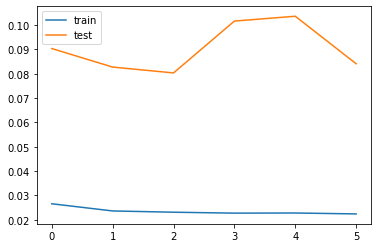

(127, 7)
(127, 7)
(127, 7)
score_train: [191.107] 173.0, 188.7, 196.7, 194.1, 184.8, 193.8, 205.1
(29, 1, 5)
score_test: [387.974] 356.8, 317.9, 133.9, 318.0, 490.1, 447.8, 515.2

RMSE test:  387.9743111164574 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0265 - val_loss: 0.1164
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0955
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1060
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0819
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0779
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0858
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              P

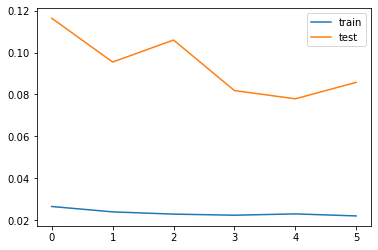

(127, 7)
(127, 7)
(127, 7)
score_train: [191.508] 173.2, 190.1, 193.9, 193.0, 186.8, 192.2, 209.5
(29, 1, 5)
score_test: [391.884] 371.5, 309.5, 145.9, 314.5, 460.2, 454.4, 550.3

RMSE test:  391.88422900773804 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 4ms/step - loss: 0.0328 - val_loss: 0.1015
Epoch 2/6
127/127 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.1007
Epoch 3/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0888
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0835
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.1104
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0984
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              

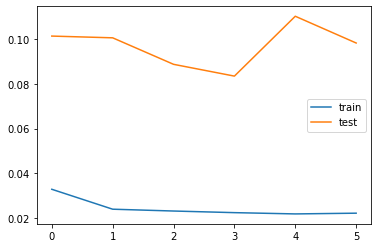

(127, 7)
(127, 7)
(127, 7)
score_train: [193.415] 175.1, 198.1, 193.7, 192.2, 183.5, 195.5, 213.5
(29, 1, 5)
score_test: [419.687] 368.2, 369.5, 163.2, 331.5, 487.6, 485.8, 592.1

RMSE test:  419.6868208051443 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0946
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0979
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0930
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0915
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0978
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0857
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              P

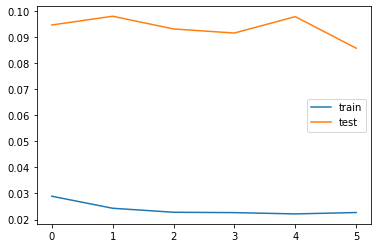

(127, 7)
(127, 7)
(127, 7)
score_train: [193.294] 174.9, 186.4, 199.7, 204.7, 185.9, 195.6, 204.0
(29, 1, 5)
score_test: [391.600] 320.5, 290.8, 181.9, 347.6, 493.4, 484.4, 504.1

RMSE test:  391.6003981964443 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1121
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1065
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.1126
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.1003
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0869
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0878
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              P

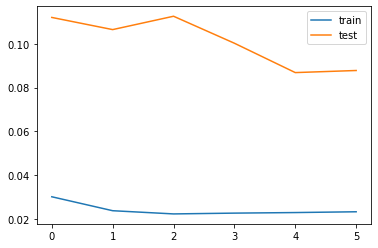

(127, 7)
(127, 7)
(127, 7)
score_train: [191.913] 175.0, 188.7, 196.5, 200.1, 185.6, 192.9, 203.0
(29, 1, 5)
score_test: [396.523] 333.8, 308.2, 177.6, 358.1, 496.9, 454.4, 530.1

RMSE test:  396.5233054754392 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.1025
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1011
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0911
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0793
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0779
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0882
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              P

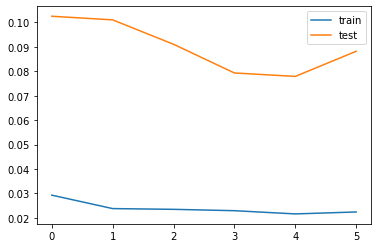

(127, 7)
(127, 7)
(127, 7)
score_train: [191.616] 175.1, 191.9, 195.5, 194.5, 185.0, 193.7, 204.4
(29, 1, 5)
score_test: [397.347] 319.6, 329.9, 176.7, 347.5, 481.1, 461.5, 545.7

RMSE test:  397.3468918906676 

7  	10    	343.037	5.68434e-14	343.037	343.037

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0905
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0727
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0856
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0831
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0831
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0762
Model: "sequential_73"
_________________________________________________________________
Layer (ty

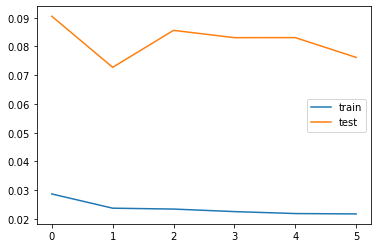

(127, 7)
(127, 7)
(127, 7)
score_train: [190.067] 171.9, 184.5, 196.1, 192.8, 188.5, 192.4, 202.7
(29, 1, 5)
score_test: [369.320] 317.1, 319.9, 194.0, 318.4, 436.1, 417.6, 498.3

RMSE test:  369.31956241657144 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1076
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0969
Epoch 3/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0881
Epoch 4/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0936
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0992
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0794
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              

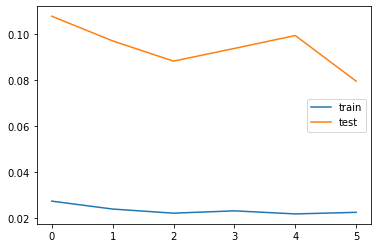

(127, 7)
(127, 7)
(127, 7)
score_train: [191.234] 172.0, 186.8, 193.1, 192.6, 183.7, 197.2, 210.9
(29, 1, 5)
score_test: [377.060] 358.6, 303.3, 152.5, 329.6, 500.1, 412.1, 472.0

RMSE test:  377.05987789879373 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0969
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0937
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0980
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0751
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0923
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0828
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              

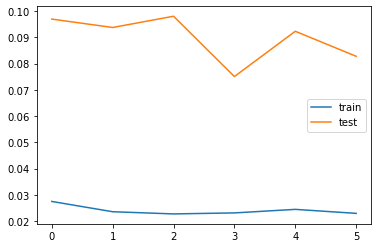

(127, 7)
(127, 7)
(127, 7)
score_train: [193.447] 177.7, 189.2, 200.9, 198.6, 190.0, 193.3, 203.2
(29, 1, 5)
score_test: [384.949] 330.7, 287.6, 134.1, 320.8, 476.1, 450.7, 542.6

RMSE test:  384.94934219186194 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0984
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1083
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0938
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0882
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0906
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0769
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              

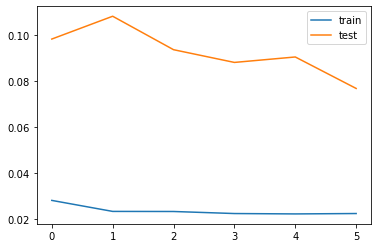

(127, 7)
(127, 7)
(127, 7)
score_train: [195.897] 172.9, 197.7, 196.2, 199.3, 188.4, 198.3, 215.8
(29, 1, 5)
score_test: [370.995] 358.7, 269.5, 175.4, 303.9, 499.9, 411.4, 469.0

RMSE test:  370.99462543921186 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1043
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0785
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.1086
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0889
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0876
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0850
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              

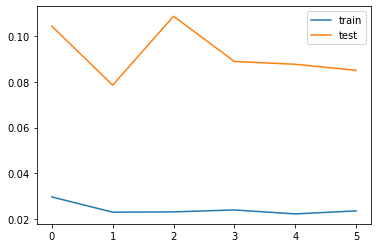

(127, 7)
(127, 7)
(127, 7)
score_train: [192.756] 174.3, 188.1, 196.0, 194.0, 183.6, 193.7, 216.8
(29, 1, 5)
score_test: [390.111] 377.7, 290.0, 129.5, 296.9, 482.2, 440.2, 554.5

RMSE test:  390.11076129324533 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0297 - val_loss: 0.0986
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0849
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0820
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0909
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0798
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0835
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              

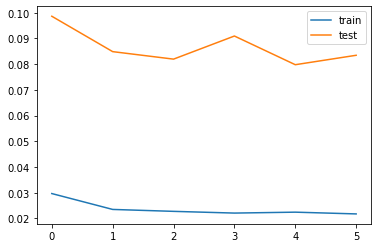

(127, 7)
(127, 7)
(127, 7)
score_train: [194.008] 175.3, 193.4, 209.7, 197.5, 184.9, 192.8, 202.5
(29, 1, 5)
score_test: [386.521] 344.7, 305.2, 124.6, 303.8, 482.6, 457.1, 533.0

RMSE test:  386.5212658642644 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1148
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1010
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0875
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0842
Epoch 5/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0845
Epoch 6/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0827
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              P

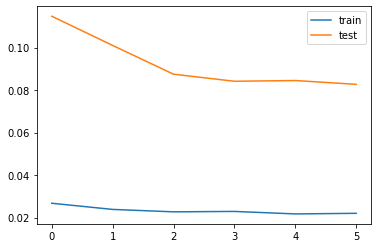

(127, 7)
(127, 7)
(127, 7)
score_train: [192.346] 173.0, 187.8, 196.8, 194.4, 186.5, 194.1, 211.7
(29, 1, 5)
score_test: [384.860] 331.9, 319.5, 186.6, 320.5, 511.5, 462.4, 460.1

RMSE test:  384.86047120052615 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0907
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0777
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0850
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0998
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0897
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0681
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              

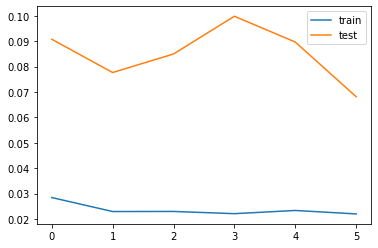

(127, 7)
(127, 7)
(127, 7)
score_train: [193.076] 178.1, 187.2, 193.8, 194.9, 191.7, 197.8, 206.8
(29, 1, 5)
score_test: [349.248] 308.1, 290.7, 137.0, 287.0, 435.5, 403.1, 470.2

RMSE test:  349.2482672289483 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1167
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1038
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0988
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.1036
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.1086
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0772
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              P

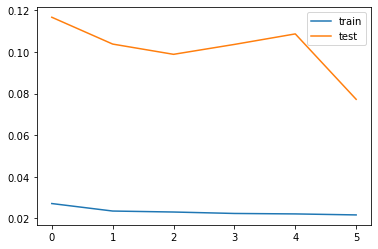

(127, 7)
(127, 7)
(127, 7)
score_train: [193.089] 174.4, 188.6, 194.9, 196.5, 184.8, 199.8, 210.6
(29, 1, 5)
score_test: [371.779] 329.4, 295.1, 124.3, 309.7, 511.1, 396.5, 492.1

RMSE test:  371.77885490277833 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.1277
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.1090
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1098
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.1102
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0992
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0775
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              

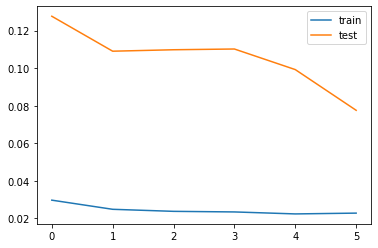

(127, 7)
(127, 7)
(127, 7)
score_train: [196.959] 172.1, 188.4, 194.6, 216.6, 191.3, 207.9, 204.5
(29, 1, 5)
score_test: [372.571] 343.8, 323.8, 155.8, 270.6, 464.8, 379.1, 539.7

RMSE test:  372.57110306335227 

8  	10    	343.037	5.68434e-14	343.037	343.037

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1164
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1073
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0974
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.1032
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0707
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0734
Model: "sequential_83"
_________________________________________________________________
Layer (t

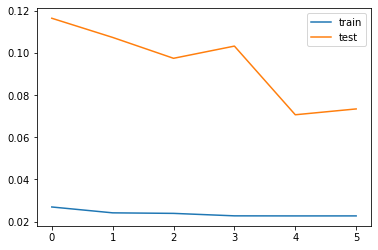

(127, 7)
(127, 7)
(127, 7)
score_train: [197.678] 172.3, 192.7, 206.2, 198.2, 213.2, 193.1, 205.4
(29, 1, 5)
score_test: [362.564] 336.0, 273.5, 125.2, 285.5, 424.2, 443.8, 508.2

RMSE test:  362.56358337556594 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.1224
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0869
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.1021
Epoch 4/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0822
Epoch 5/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0825
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0885
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              

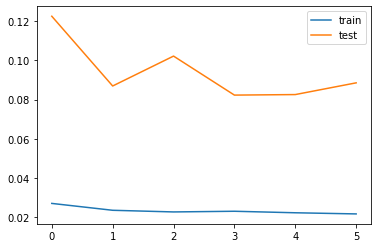

(127, 7)
(127, 7)
(127, 7)
score_train: [191.369] 172.4, 192.4, 195.5, 195.2, 183.7, 194.0, 204.8
(29, 1, 5)
score_test: [398.005] 344.5, 329.8, 175.3, 355.3, 475.5, 495.0, 503.3

RMSE test:  398.0049281630809 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0969
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.1080
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0802
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0777
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0996
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0996
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              P

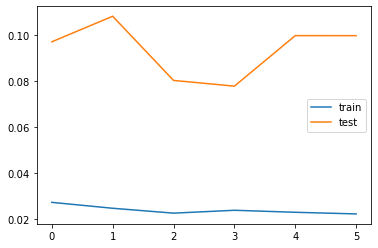

(127, 7)
(127, 7)
(127, 7)
score_train: [193.245] 176.2, 187.9, 200.0, 193.4, 185.3, 206.9, 201.1
(29, 1, 5)
score_test: [422.274] 388.5, 323.4, 185.8, 323.2, 539.7, 540.7, 519.7

RMSE test:  422.2735118842046 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0948
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.1035
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1042
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0913
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1009
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0843
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              P

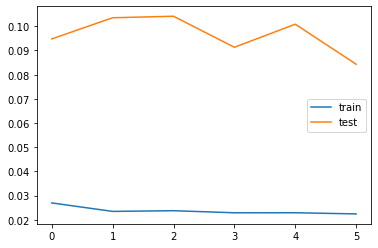

(127, 7)
(127, 7)
(127, 7)
score_train: [190.513] 171.4, 188.2, 195.2, 195.0, 184.3, 193.8, 203.9
(29, 1, 5)
score_test: [388.516] 364.6, 309.4, 127.0, 320.7, 521.1, 426.6, 505.4

RMSE test:  388.5157245816213 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0803
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0811
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0915
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0768
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0823
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0835
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              P

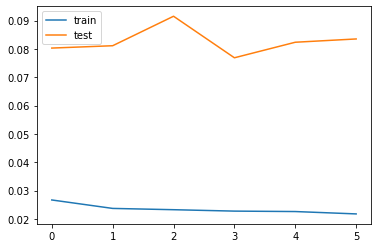

(127, 7)
(127, 7)
(127, 7)
score_train: [192.843] 171.9, 188.4, 202.1, 194.2, 184.1, 202.1, 204.7
(29, 1, 5)
score_test: [386.610] 332.8, 303.0, 181.0, 320.0, 479.8, 480.7, 497.3

RMSE test:  386.6096813796347 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 1s 5ms/step - loss: 0.0289 - val_loss: 0.1020
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1024
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0884
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0825
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0866
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0837
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              P

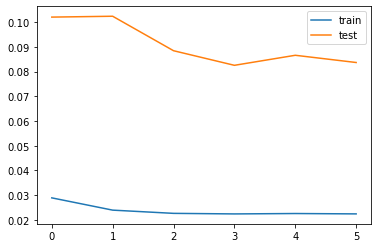

(127, 7)
(127, 7)
(127, 7)
score_train: [191.357] 172.5, 186.8, 198.1, 195.6, 185.2, 193.7, 205.8
(29, 1, 5)
score_test: [387.013] 342.2, 306.2, 121.3, 300.7, 469.4, 454.7, 552.6

RMSE test:  387.01268688900035 

9  	6     	343.037	5.68434e-14	343.037	343.037

Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.1132
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0873
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0709
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0715
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0850
Epoch 6/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0215 - val_loss: 0.0801
Model: "sequential_89"
_________________________________________________________________
Layer (t

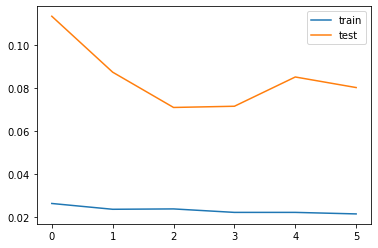

(127, 7)
(127, 7)
(127, 7)
score_train: [190.349] 175.4, 188.7, 193.0, 191.9, 183.8, 192.0, 206.2
(29, 1, 5)
score_test: [378.761] 308.0, 286.7, 128.5, 319.7, 501.0, 453.1, 502.2

RMSE test:  378.7614475546883 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.1127
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.1020
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.1029
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0812
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0942
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0885
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              P

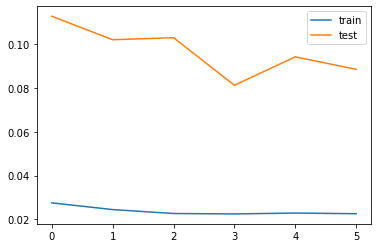

(127, 7)
(127, 7)
(127, 7)
score_train: [193.190] 173.8, 189.7, 209.3, 195.6, 185.7, 192.6, 203.6
(29, 1, 5)
score_test: [397.981] 327.8, 304.6, 219.0, 346.6, 518.4, 437.2, 529.7

RMSE test:  397.9811450134767 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1046
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0850
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0987
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0841
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0811
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0691
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              P

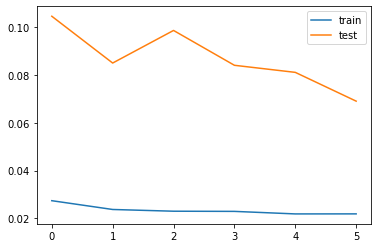

(127, 7)
(127, 7)
(127, 7)
score_train: [196.407] 184.8, 193.9, 197.0, 195.5, 185.0, 195.5, 220.9
(29, 1, 5)
score_test: [351.669] 300.6, 262.6, 134.0, 293.6, 477.2, 428.6, 436.8

RMSE test:  351.6688476758032 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1077
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1021
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0893
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0798
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0792
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0843
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              P

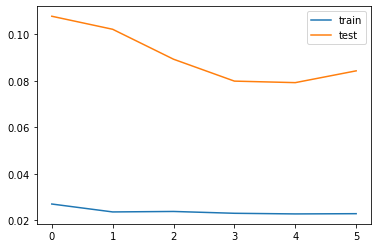

(127, 7)
(127, 7)
(127, 7)
score_train: [190.498] 173.4, 190.8, 193.4, 194.4, 184.6, 192.2, 203.3
(29, 1, 5)
score_test: [388.376] 357.7, 327.0, 140.0, 296.1, 489.6, 447.8, 522.9

RMSE test:  388.375701367146 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.1035
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0965
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0760
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0856
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0783
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0829
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

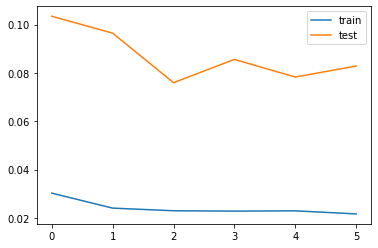

(127, 7)
(127, 7)
(127, 7)
score_train: [191.017] 172.9, 187.6, 194.5, 194.0, 184.8, 195.6, 206.0
(29, 1, 5)
score_test: [385.140] 353.6, 298.5, 142.0, 314.5, 483.5, 460.3, 509.5

RMSE test:  385.1400928112504 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1106
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1054
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0836
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0888
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0895
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0788
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              P

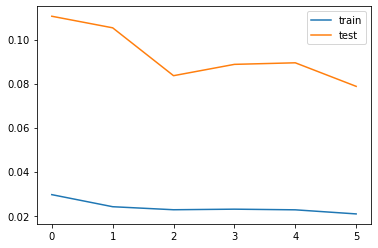

(127, 7)
(127, 7)
(127, 7)
score_train: [192.099] 173.5, 187.4, 193.3, 197.6, 194.4, 193.1, 204.0
(29, 1, 5)
score_test: [375.515] 355.9, 323.7, 141.2, 275.0, 446.8, 449.5, 508.3

RMSE test:  375.5152257328908 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.1259
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0921
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0987
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0959
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0967
Epoch 6/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0917
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              P

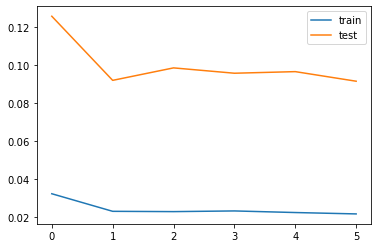

(127, 7)
(127, 7)
(127, 7)
score_train: [192.917] 173.3, 193.7, 196.4, 193.2, 184.8, 194.9, 212.0
(29, 1, 5)
score_test: [405.119] 372.6, 333.5, 168.7, 304.1, 476.2, 468.8, 575.6

RMSE test:  405.1194271372606 


Units CNN1:  255 ,Sequence size:  1
(127, 1, 5)
Epoch 1/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.1135
Epoch 2/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0885
Epoch 3/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0857
Epoch 4/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0797
Epoch 5/6
127/127 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0864
Epoch 6/6
127/127 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0975
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              P

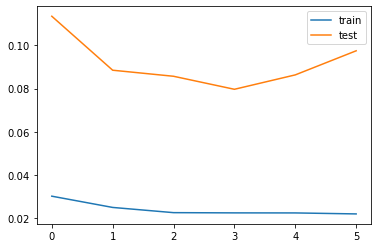

(127, 7)
(127, 7)
(127, 7)
score_train: [199.036] 179.9, 205.3, 203.2, 211.4, 186.1, 199.4, 206.0
(29, 1, 5)
score_test: [417.798] 357.1, 344.0, 191.2, 376.0, 525.0, 485.3, 535.7

RMSE test:  417.798412419066 

10 	8     	343.037	5.68434e-14	343.037	343.037


In [74]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =8 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [75]:
print('Best score :', best_score)

Best score : 343.0372783973723


In [76]:
model=model_name
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 1, 255)            2805      
_________________________________________________________________
flatten_49 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 7)                 1792      
Total params: 4,597
Trainable params: 4,597
Non-trainable params: 0
_________________________________________________________________


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14,21,28]])
yhat.shape 

(5, 7)

In [78]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [79]:
#yhat

In [80]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14,21,28]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)

In [81]:
days

DatetimeIndex(['2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [82]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:35]
test_res['real']=y_test_true.flatten()[0:35]
test_res.set_index(days,inplace=True)

In [83]:
test_res

,Prediction,real
timestamp,,
2020-07-12,252.811478,214.000000
2020-07-13,232.084030,203.000015
2020-07-14,269.989258,190.999985
2020-07-15,292.300903,161.000000
2020-07-16,260.408966,165.000000
2020-07-17,286.723328,162.000000
2020-07-18,261.057343,302.000000
2020-07-19,309.993744,289.000000
2020-07-20,264.117218,220.999985


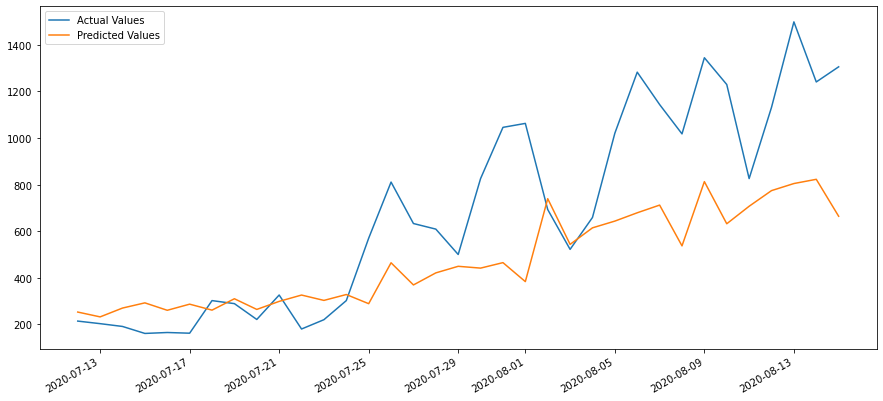

In [84]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [85]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 117674.57
RMSE: 343.04
MAE: 257.94
R Squared: 0.34
Max Error: 694.27


In [86]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(127, 7)

In [87]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(127, 7)

In [88]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [89]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [90]:
y_train_pred[0]

array([247.90547, 219.76003, 235.09259, 256.25043, 238.80069, 266.50317,
       249.93007], dtype=float32)

In [91]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
y_train_pred = y_train_pred [filter_indices ]

In [92]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [93]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(127, 1, 5)

In [94]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [95]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

133

In [96]:
date_train = date_train.values.flatten()

In [97]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [98]:
Y_train_pred.shape

(126,)

In [99]:
Y_train_real.shape

(126,)

In [100]:
date_train.shape

(134,)

In [101]:
date_train[nb_seq:].shape

(133,)

In [102]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-7

In [103]:
Y_train_real[:-suite_size].shape

(7,)

In [104]:
date_train[nb_seq:].shape

(133,)

In [105]:
Y_train_pred[:-suite_size].shape

(7,)

In [106]:
Y_train_real[:-suite_size].shape

(7,)

In [107]:
date_trainX = date_train[nb_seq:]

In [108]:
date_trainX[0:Y_train_pred.shape[0]].shape

(126,)

In [109]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [110]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [111]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [112]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-03,163.080872,247.905472
2020-03-04,175.566101,219.760025
2020-03-05,175.566101,235.092590
2020-03-06,163.080872,256.250427
2020-03-07,175.566101,238.800690
2020-03-08,175.566101,266.503174
2020-03-09,175.566101,249.930069
2020-03-10,175.566101,247.905472
2020-03-11,175.566101,219.760025


In [113]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-06-27,774.856934,602.267029
2020-06-28,668.732544,637.423767
2020-06-29,525.152405,578.041321
2020-06-30,656.247314,653.680481
2020-07-01,666.651672,571.637207
2020-07-02,375.329742,625.357605
2020-07-03,853.929993,663.472595
2020-07-04,824.797852,634.047852
2020-07-05,1272.185059,674.510559


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

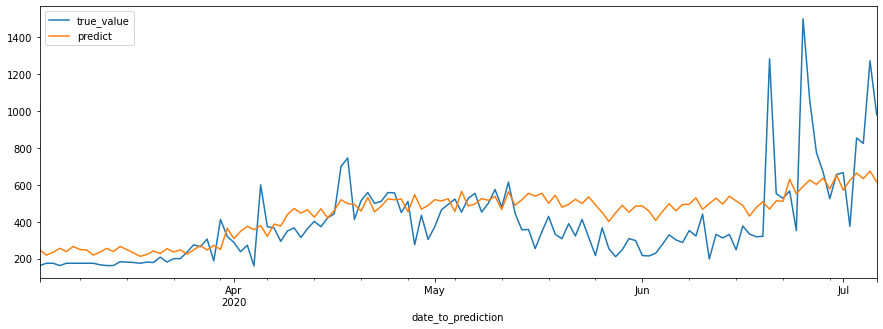

In [114]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [115]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 39459.43
RMSE 198.64
MAE 139.78
R2 0.29
maxError 965.54
